![title](https://www.educafro.org.br/site/wp-content/uploads/2020/10/faculdade-insper-logo.png)

# APS Python para Ciência de Dados:

**Grupo:** Arthur Wachslicht, Gabriel Prado, Luiz Felipe Souza e Pedro Osorio Magaldi Netto

**Link .zip no Drive:** https://drive.google.com/file/d/1csJ4jFuOCSIqGVKBEhwKKgE3E4M25O_O/view?usp=sharing

## Descrição da base

A base analisada contém dados históricos referentes às taxas cobradas por diversas faculdades americanas, além de outras informações sobre as instituições, como a quantidade de alunos, a diversidade da universidade e o salário esperado dos estudantes imediatamente após a formatura.

Por meio desta análise, buscamos entender as características das faculdades que levam a um maior ou menor salário esperado após a formatura. Para tal, iniciamos nosso estudo com uma análise descritiva, buscando entender a relação entre os fatores de forma visual. Feita essa análise, partimos para o desenvolvimento de diversos modelos, focando tanto em inferência quanto em capacidade preditiva. Utilizaremos os métodos de **regressão linear**, **random forest** e **gradient boosted decision trees** para desenvolver nossa análise, separando a base em treino e teste no processo, para garantir a confiabilidade das métricas dos modelos.

# Dicionário das Variáveis

### Dicionário disponível em https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-03-10/readme.md

# `tuition_cost.csv`

|variable             |class     |description |
|:--------------------|:---------|:-----------|
|name                 |character |School name |
|state                |character | State name |
|state_code           |character | State Abbreviation |
|type                 |character | Type: Public, private, for-profit|
|degree_length        |character | 4 year or 2 year degree |
|room_and_board       |double    | Room and board in USD |
|in_state_tuition     |double    | Tuition for in-state residents in USD |
|in_state_total       |double    | Total cost for in-state residents in USD (sum of room & board + in state tuition) |
|out_of_state_tuition |double    | Tuition for out-of-state residents in USD|
|out_of_state_total   |double    | Total cost for in-state residents in USD (sum of room & board + out of state tuition) |

# `tuition_income.csv`

|variable    |class     |description |
|:-----------|:---------|:-----------|
|name        |character | School name |
|state       |character | State Name |
|total_price |double    | Total price in USD |
|year        |double    | year |
|campus      |character | On or off-campus |
|net_cost    |double    | Net-cost - average actually paid after scholarship/award |
|income_lvl  |character | Income bracket |

# `salary_potential.csv`

|variable                  |class     |description |
|:-------------------------|:---------|:-----------|
|rank                      |double    | Potential salary rank within state |
|name                      |character | Name of school |
|state_name                |character | state name |
|early_career_pay          |double    | Estimated early career pay in USD |
|mid_career_pay            |double    | Estimated mid career pay in USD |
|make_world_better_percent |double    | Percent of alumni who think they are making the world a better place |
|stem_percent              |double    | Percent of student body in STEM |

# `historical_tuition.csv`

|variable     |class     |description |
|:------------|:---------|:-----------|
|type         |character | Type of school (All, Public, Private) |
|year         |character | Academic year |
|tuition_type |character | Tuition Type All Constant (dollar inflation adjusted), 4 year degree constant, 2 year constant, Current to year, 4 year current, 2 year current |
|tuition_cost |double    | Tuition cost in USD |

# `diversity_school.csv`
|variable         |class     |description |
|:----------------|:---------|:-----------|
|name             |character | School name |
|total_enrollment |double    | Total enrollment of students |
|state            |character | State name |
|category         |character | Group/Racial/Gender category |
|enrollment       |double    | enrollment by category |

### Importando as bibliotecas necessárias:

In [2]:
import pandas as pd
from siuba import *
from plotnine import *
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

theme_set(theme_bw())

### Importando os dados:

In [3]:
tuition_cost = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_cost.csv')
tuition_income = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_income.csv')
salary_potential = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/salary_potential.csv')
historical_tuition = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/historical_tuition.csv')
diversity_school = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/diversity_school.csv')

### Diversidade nas Universidades

In [4]:
diversity_percent = (diversity_school.dropna(subset=["name"]) >>
    spread(_.category, _.enrollment) >>
    transmute(_.name,
              pminority = _["Total Minority"] / _.total_enrollment,
              pforeign = _["Non-Resident Foreign"] / _.total_enrollment,
              pwomen = _["Women"] / _.total_enrollment))

### Número de estudante de cada categoria:

In [5]:
(diversity_school>>
    group_by(_.category)>>
    summarize(total_number=_.enrollment.sum()) >>
    arrange(-_.total_number))

,category,total_number
10,Women,11406332
9,White,10594649
6,Total Minority,7609693
3,Hispanic,3038062
2,Black,2623032
1,Asian,1152396
8,Unknown,1079537
5,Non-Resident Foreign,916832
7,Two Or More Races,595001
0,American Indian / Alaska Native,145875


### % médio de cada category nas universidades:

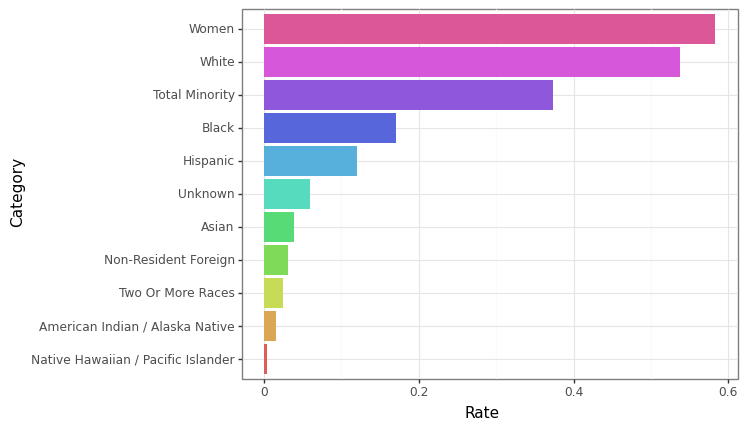

<ggplot: (159969306191)>

In [6]:
categories = (diversity_school >>
    mutate(rate=(_.enrollment/_.total_enrollment)) >>
    group_by(_.category)>>
    summarize(mean_rate=_.rate.mean()) >>
    arrange(_.mean_rate))["category"]

(diversity_school >>
    mutate(rate = (_.enrollment/_.total_enrollment),
           category = pd.Categorical(diversity_school["category"], categories = categories)) >>
    group_by(_.category) >>
    summarize(mean_rate=_.rate.mean()) >>
    ggplot(aes(x = "category", y = "mean_rate", fill = "category")) +
    geom_col(show_legend = False) +
    labs(x = "Category", y = "Rate") +
    coord_flip())

### Early Carrer Pay x Mid Carrer Pay

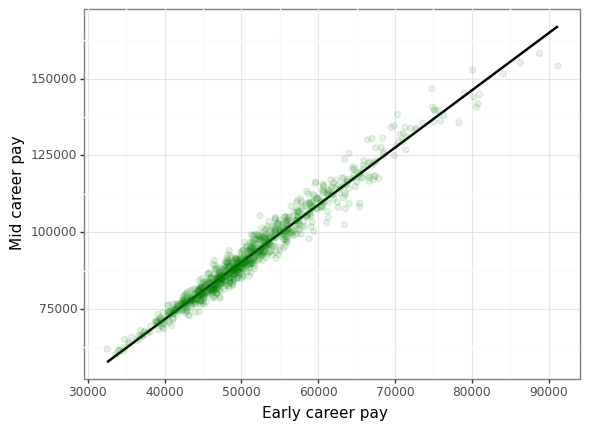

<ggplot: (159969384500)>

In [7]:
(salary_potential>>
    ggplot(aes(x="early_career_pay",y="mid_career_pay"))
    +labs(x="Early career pay",y="Mid career pay")
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .1))

Podemos perceber como a relação é muito intuitiva entre Early Career Pay e Mid Career Pay.

### Instituições mais caras:

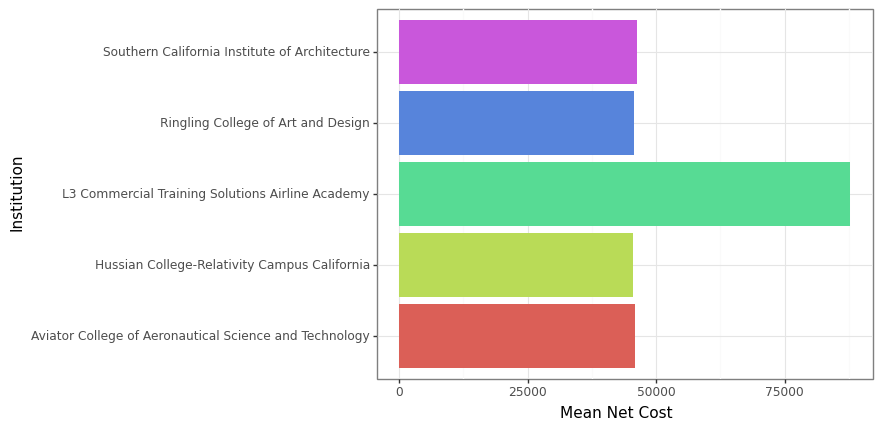

<ggplot: (159973107261)>

In [8]:
(tuition_income >> 
    group_by(_.name) >> 
    summarize(mean_net_cost=_.net_cost.mean())>>
    arrange(-_.mean_net_cost)>>
    head(5)>>
    ggplot(aes(x="name",y="mean_net_cost",fill="name"))
    +labs(x="Institution",y="Mean Net Cost",main="Most Expensive Universities")
    +geom_col(alpha=1,show_legend=False)
    +coord_flip())

Neste item, observamos como há complexidade em analisar conjuntamente estas universidades, visto que são muito diversas em cursos disponibilizados. Neste caso, podemos ver como a instituição de treinamento para aviação comercial foge à Tuition normal das outras disponíveis na base de dados.

### Stem Percent x Mid Carrer Pay:

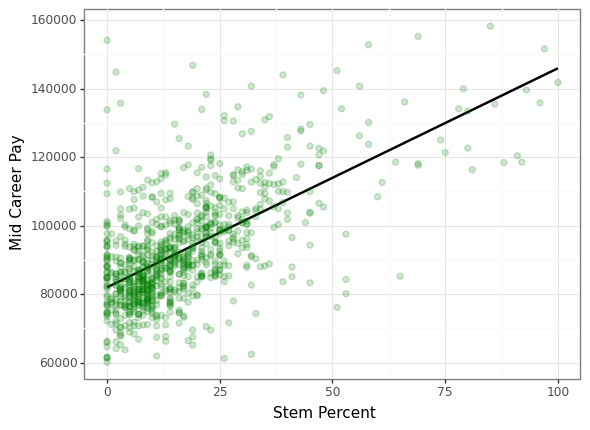

<ggplot: (159973109026)>

In [9]:
(salary_potential>>
    ggplot(aes(x="stem_percent",y="mid_career_pay"))
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .2)
    +labs(x="Stem Percent",y="Mid Career Pay"))

Podemos perceber como instituições com maior concentração de alunos da área de ciências, tecnologia, engenharia e matemática aparentemente tendem a ter Mid Career Pay mais alto.

### Make World Better Percent x Mid Carrer Pay:

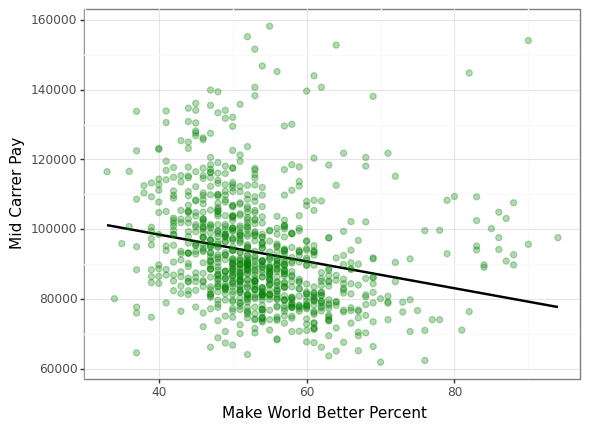

<ggplot: (96887107021)>

In [9]:
(salary_potential.dropna()>>
    ggplot(aes(x="make_world_better_percent",y="mid_career_pay"))+
    geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
    geom_point(color="green",size=2, alpha = .3)
    +labs(x="Make World Better Percent",y="Mid Carrer Pay"))

Neste caso, apesar de grande dispersão aparente, podemos perceber que, no geral, aparentemente o Mid Career Pay está negativamente relacionado com a concentração de alunos que acreditam que estão tornando o mundo melhor na instituição. Neste caso, apesar de não aprofundarmos neste tema, surge interessante pergunta a ser respondida em outras análises - por que esta relação?

### Custo médio de tuition por nível de renda:

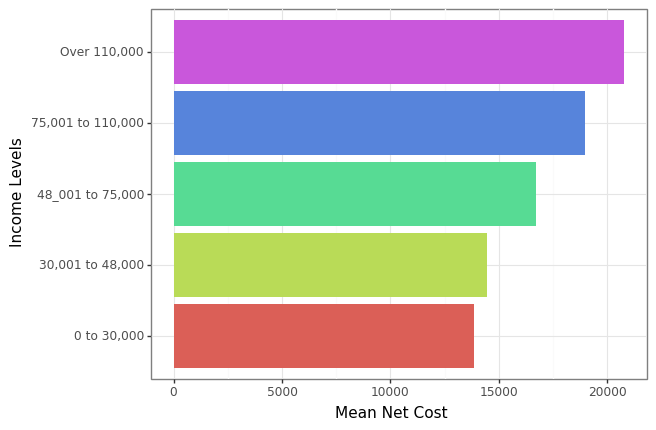

<ggplot: (96887129869)>

In [10]:
(tuition_income>>
      group_by(_.income_lvl)>>
      summarize(mean_net_cost=_.net_cost.mean())>>
      arrange(-_.mean_net_cost) >>
      ggplot(aes(x="income_lvl",y="mean_net_cost",fill="income_lvl"))+
      labs(x="Income Levels",y="Mean Net Cost",main="Mean Net Cost per Income Level")+
      geom_col(alpha=1, show_legend = False)+
      coord_flip())

Como esperado, o custo de Tuition cresce conjuntamente com as faixas de renda.

### Médias salariais por estado:

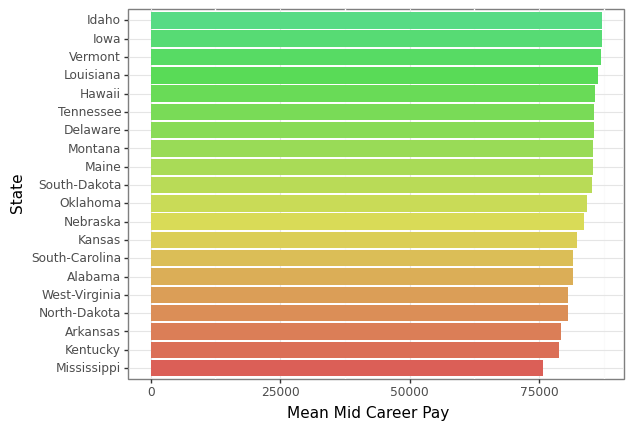

<ggplot: (96887136043)>

In [11]:
categories = (salary_potential >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    arrange(_.mean_mid_career_pay))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_mid_career_pay", fill = "state_name")) +
    geom_col(alpha=1, show_legend = False) +
    labs(x = "State", y = "Mean Mid Career Pay") +
    coord_flip())

De forma interessante, ao observar o Mid Career Pay por estado na base de dados, não encontramos os estados mais famosos no topo quando se tratando dos Estados Unidos, como a California e Nova Iorque.

### Média de stem percent por estado:

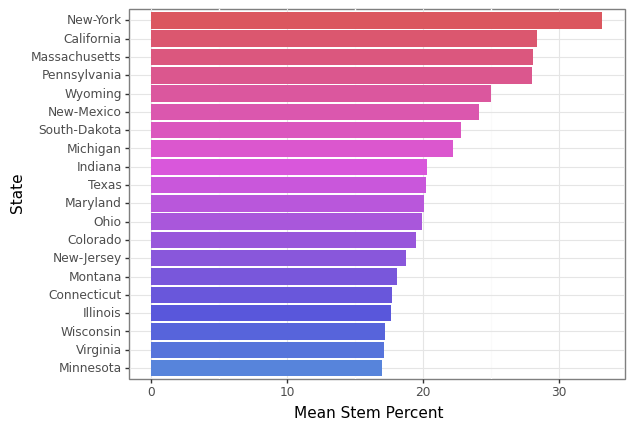

<ggplot: (96887212039)>

In [12]:
categories = (salary_potential >>
                group_by(_.state_name)>>
                summarize(mean_stem_percent=_.stem_percent.mean())>>
                arrange(_.mean_stem_percent))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_stem_percent=_.stem_percent.mean()) >>
    arrange(-_.mean_stem_percent) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_stem_percent", fill = "state_name")) +
    geom_col(show_legend = False) +
    labs(x = "State", y = "Mean Stem Percent") +
    coord_flip())

### Custo de room and board por estado:

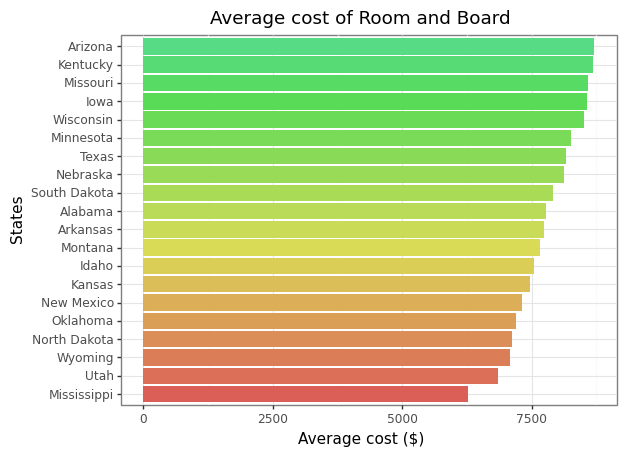

<ggplot: (159973168282)>

In [10]:
theme_set(theme_bw())

order_states = (tuition_cost >>
                group_by(_.state) >>
                summarize(avg_room_board = _.room_and_board.mean()) >>
                arrange(_.avg_room_board))["state"]

(tuition_cost >>
    mutate(state = pd.Categorical(tuition_cost["state"], categories=order_states)) >>
    group_by(_.state) >>
    summarize(avg_room_board = _.room_and_board.mean()) >>
    head(20) >>
    ggplot(aes("state", "avg_room_board")) +
    geom_col(aes(fill = "state"), show_legend = False) +
    coord_flip() +
    labs(x = "States",
         y = "Average cost ($)",
         title = "Average cost of Room and Board"))

Novamente, ficamos surpresos por não encontrar estados como Nova Iorque ou California como aqueles mais caros no quesito custo de estadia.

### % Médio de alunos brancos nas universidades, estados com maior numero:

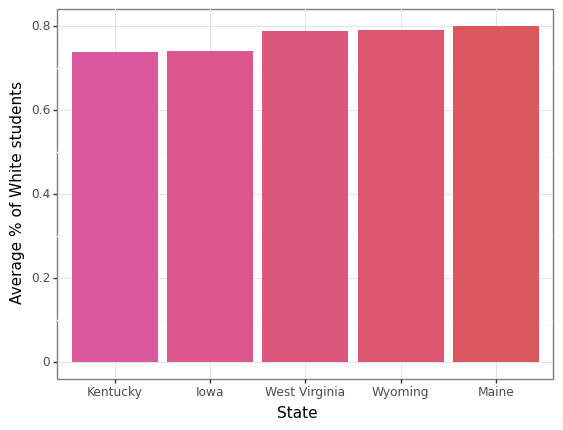

<ggplot: (96884571245)>

In [14]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate = (_.enrollment / _.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states)) >>
        group_by(_.state,_.category) >>
        summarize(mean_rate = _.rate.mean()) >>
        filter(_.category == "White") >>
        arrange(-_.mean_rate) >>
        head(5) >>
        ggplot(aes(x = "state", y = "mean_rate", fill = "state")) +
        labs(x = "State", y = "Average % of White students") +
        geom_col(alpha = 1, show_legend = False))

### % Médio de alunos brancos nas universidades, estados com menor numero:

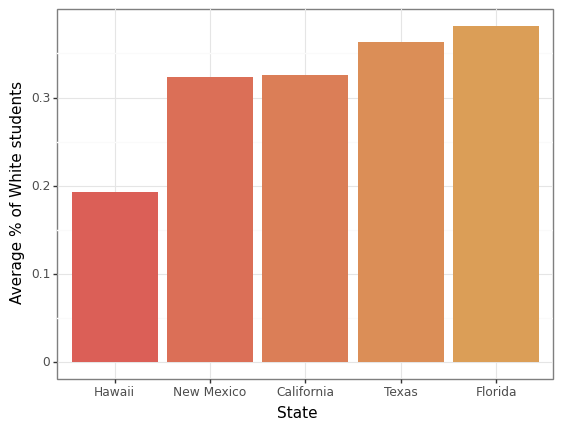

<ggplot: (96884562173)>

In [15]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate=(_.enrollment/_.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states))>>
        group_by(_.state,_.category)>>
        summarize(mean_rate=_.rate.mean())>>
        filter(_.category=="White")>>
        arrange(_.mean_rate)>>
        head(5)>>
        ggplot(aes(x="state",y="mean_rate",fill="state"))+
        labs(x="State",y="Average % of White students")+
        geom_col(alpha=1, show_legend = False))

Neste item, achamos interessante como a porcentagem de alunos brancos no Havaí é baixa. Como esperado, encontramos estados famosos pela presença de estrangeiros no topo desta lista, como Flórida e California.

### Relação entre diversidade e salário inicial na carreira


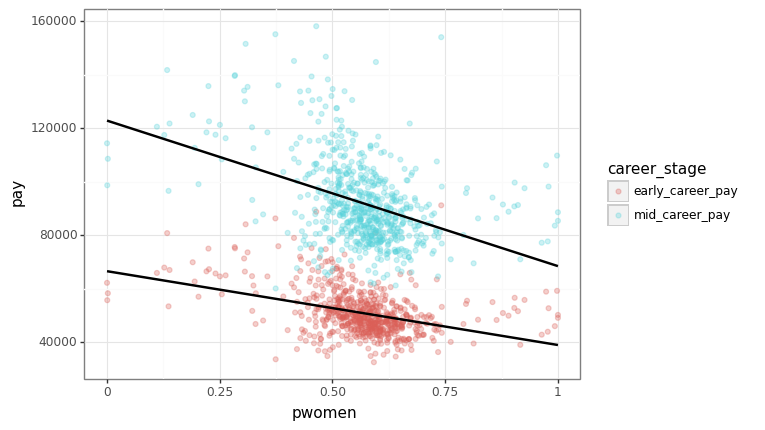

<ggplot: (96884047665)>

In [16]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pwomen", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

A grande disperção dos dados aparente nas faixas fora dos 50% a 75% de mulheres na instituição torna ineficiente a análise visual da relação, mas podemos observar que há certa tendência de universidades com maior concentração de mulheres possuir menor salário que com de homens.

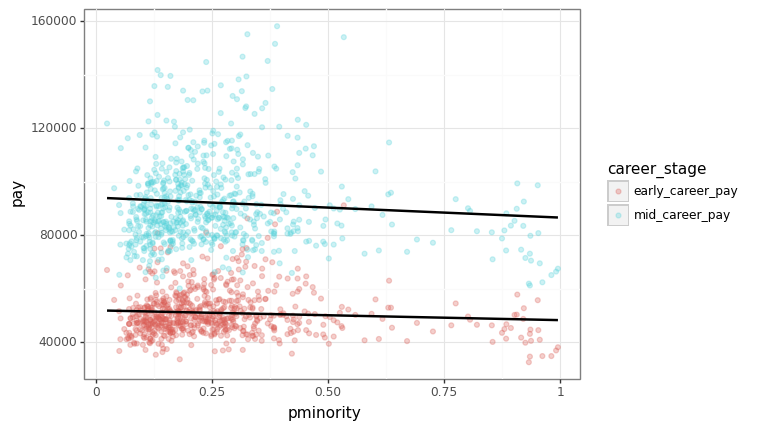

<ggplot: (96887176412)>

In [17]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pminority", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

Aqui, pudemos ver que aparentemente diversidade de forma absoluta não afeta muito o salário.

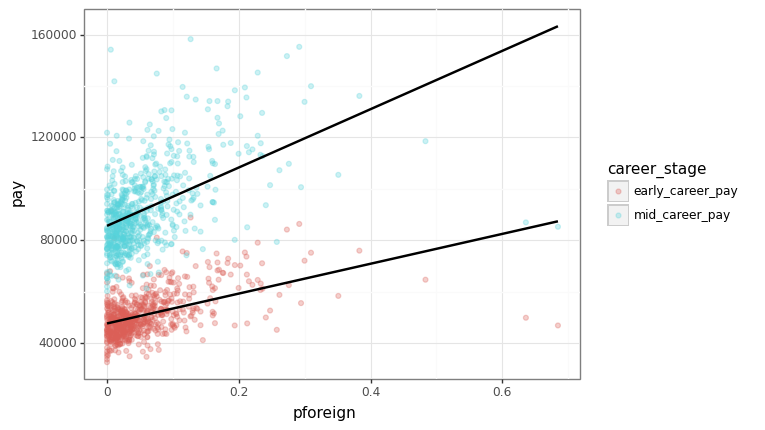

<ggplot: (159973185142)>

In [11]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pforeign", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

Por sua vez, achamos interessante a relação entre a porcentagem de estrangeiros na instituição e o salário, porém há muita concentração de dados na faixa inicial, o que torna não muito eficiente a longa linha de tendência teórica.

### Regressão linear para propósitos de inferência:

$$ \large{ {Y}_{i} = \beta_{0} + \beta_{1} \ln{{X}_{1i}} + \beta_{2} {X}_{2i} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{early_career_pay}\\
{X}_{1i} &=\texttt{make_world_better_percent}\\
{X}_{2i} &=\texttt{stem_percent} 
\end{split}$$

In [12]:
lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", salary_potential).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mid_career_pay   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     318.9
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          2.12e-105
Time:                        15:38:28   Log-Likelihood:                -9749.3
No. Observations:                 902   AIC:                         1.950e+04
Df Residuals:                     899   BIC:                         1.952e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          1.352e+05      1e+04     13.457      0.000    1.15e+05    1.55e+05
np.log(make_world_better_percent) -1.331e+04   2502.304     -5.320      0.000   -1.82e+04   -8400.718
stem_percent                        626.4771     26.939     23.256      0.000     573.607     679.347
==============================================================================
Omnibus:                      219.140   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.333
Skew:                           1.118   Prob(JB):                    2.44e-177
Kurtosis:                       7.080   Cond. No.                         600.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regressão linear para previsão

In [20]:
train, test = train_test_split(salary_potential.dropna(), test_size = 0.7, random_state = 1234) 

lm = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", data = train).fit()

lm_hat = lm.predict(test)
print("RMSE:", np.sqrt(mean_squared_error(test.early_career_pay, lm_hat)).round(2), "\n")
print("R-squared:", r2_score(test.early_career_pay, lm_hat).round(4))

RMSE: 42136.03 

R-squared: -25.1098


Para realizarmos um modelo mais voltado à predição buscamos garantir que as métricas de avaliação do modelo sejam as mais confiáveis possíveis. Para isso, separamos a base de dados original em uma porção de treino e outra de teste, de forma que as métricas de qualidade dos modelos sejam coletadas em uma parcela dos dados não utilizada no treino deste. 

Utilizamos, nesta etapa, o mesmo modelo utilizado previamente - o de regressão linear - para fazer nossas previsões, método baseado na metodologia OLS para chegar a seus resultados. Obtemos um resultado razoável, com 34.11% de R-quadrado e 6693.72 de raiz do erro quadrático médio. O R-quadrado, essencialmente, indica a correlação entre os resultados previstos e os dados observados, sendo 34% um bom resultado para o modelo analisado, aparentemente. Já o RMSE mede o desvio médio entre o resultado previsto e o observado. Como o valor é de 6693.72, dado que a variância da variáveis prevista é de 15856.48, o erro parece ser razoável.

### Modelo Random Forest para previsão

In [21]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_trn, y_trn.ravel())

rf_hat = rf.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, rf_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, rf_hat).round(4))

RMSE: 10283.2 

R-squared: 0.5579


Buscando um melhor resultado para as previsões, rodamos também um modelo de Random Forest, um modelo baseado em árvores de decisão que consegue excelentes resultados por meio do processo de *bagging*. Apesar de um RMSE maior, o R-quadrado do método Random Forest se mostrou muito melhor do que na regressão linear. Isso pode resultar de resultados em geral mais condizentes com os valores observados, mas com erros mais significativos.

### Boosted Decision Tree para previsão

In [23]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

boost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 200)
boost.fit(X_trn, y_trn.ravel())

boost_hat = boost.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, boost_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, boost_hat).round(4))

RMSE: 10968.66 

R-squared: 0.497


Como um último modelo preditivo, utilizamos a técnica de Boosting para regressão. Esse método treina, de forma sequencial, diversas árvores de regressão, utilizando o erro quadrático médio como função de perda e treinando as próximas árvores nos erros das árvores anteriores.

## Inferência: Tuition vs Mid career pay

In [24]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent + net_cost + type", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mid_career_pay   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.422e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        07:23:37   Log-Likelihood:            -5.6592e+05
No. Observations:               53053   AIC:                         1.132e+06
Df Residuals:                   53048   BIC:                         1.132e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           1.77e+05   1262.607    140.158      0.000    1.74e+05    1.79e+05
type[T.Public]                    -2908.2989    107.598    -27.029      0.000   -3119.191   -2697.407
np.log(make_world_better_percent)  -2.49e+04    305.936    -81.398      0.000   -2.55e+04   -2.43e+04
stem_percent                        589.6350      3.072    191.943      0.000     583.614     595.656
net_cost                              0.2424      0.007     36.392      0.000       0.229       0.255
==============================================================================
Omnibus:                    11429.916   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49784.277
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       7.304   Cond. No.                     6.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Inferência: Make World Better vs Tuition

In [25]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("np.log(make_world_better_percent) ~ net_cost + type + stem_percent", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log(make_world_better_percent)   R-squared:                       0.070
Model:                                           OLS   Adj. R-squared:                  0.070
Method:                                Least Squares   F-statistic:                     1330.
Date:                               Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                                       07:24:26   Log-Likelihood:                 26306.
No. Observations:                              53053   AIC:                        -5.260e+04
Df Residuals:                                  53049   BIC:                        -5.257e+04
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0910      0.002   1732.219      0.000       4.086       4.096
type[T.Public]    -0.0252      0.002    -16.538      0.000      -0.028      -0.022
net_cost         -4.7e-06   9.23e-08    -50.915      0.000   -4.88e-06   -4.52e-06
stem_percent      -0.0014   4.32e-05    -33.156      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      484.676   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.579
Skew:                           0.146   Prob(JB):                    5.28e-137
Kurtosis:                       3.445   Cond. No.                     8.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""